# Compare PODs after performing int and log10 transforms of MD

In [39]:
import polars as pl
import pandas as pd
from scipy.stats import ttest_rel, pearsonr
import numpy as np


output_dir = "../1_snakemake/outputs"
input_dir = "../1_snakemake/inputs"

In [40]:
conc_conv = pl.read_parquet(f"{input_dir}/metadata/metadata.parquet")
conc_conv = conc_conv.filter(pl.col("Metadata_Compound") != "DMSO").select(
    ["Metadata_Compound", "Metadata_Concentration"]
).group_by("Metadata_Compound").agg([
    pl.col("Metadata_Concentration").min().alias("Metadata_Min_Conc")
])

conc_conv = conc_conv.with_columns(
    (pl.col("Metadata_Min_Conc")/3).log10().abs().alias("Metadata_Conc_Shift")
)

def conv_POD_um(pod_df, conv_df, pod_col, conv_pod_nm):
    pod_df = pod_df.join(conv_df, on="Metadata_Compound")

    pod_df = pod_df.with_columns(
        (10 ** (pl.col(pod_col) - pl.col("Metadata_Conc_Shift"))).alias(conv_pod_nm)
    ).drop(["Metadata_Min_Conc", "Metadata_Conc_Shift"])

    return pod_df

## Compare PODs across transforms

In [55]:
features = "cellprofiler"

reg_dir = f"{output_dir}/{features}/mad_featselect/curves"
int_dir = f"{output_dir}/{features}/mad_int_featselect/curves"
log10_dir = f"{output_dir}/{features}/mad_featselect_log10/curves"

reg = pl.read_parquet(f"{reg_dir}/pods.parquet").select(["Metadata_Compound", "bmd"]).rename({"bmd": f"Metadata_{features}_POD"})
reg = conv_POD_um(reg, conc_conv, f"Metadata_{features}_POD", f"Metadata_{features}_POD_um")

invt = pl.read_parquet(f"{int_dir}/pods.parquet").select(["Metadata_Compound", "bmd"]).rename({"bmd": f"Metadata_{features}_int_POD"})
invt = conv_POD_um(invt, conc_conv, f"Metadata_{features}_int_POD", f"Metadata_{features}_int_POD_um")

log10 = pl.read_parquet(f"{log10_dir}/pods.parquet").select(["Metadata_Compound", "bmd"]).rename({"bmd": f"Metadata_{features}_log10_POD"})
log10 = conv_POD_um(log10, conc_conv, f"Metadata_{features}_log10_POD", f"Metadata_{features}_log10_POD_um")

In [56]:
data = reg.join(invt, on="Metadata_Compound", how="left")
data = data.join(log10, on="Metadata_Compound", how="left")

In [57]:
# Log10 scale
all_pods = data.select([
    "Metadata_Compound",
    f"Metadata_{features}_POD",
    f"Metadata_{features}_int_POD",
    f"Metadata_{features}_log10_POD",
]).unique()

all_pods_long = all_pods.unpivot(
    index=["Metadata_Compound"],
    on=[f"Metadata_{features}_POD", f"Metadata_{features}_int_POD", f"Metadata_{features}_log10_POD"],
    variable_name="POD_Type",
    value_name="POD_Value"
).drop_nulls().to_pandas()

all_pods_long['POD_Type'] = pd.Categorical(
    all_pods_long['POD_Type'],
    categories=[f"Metadata_{features}_POD", f"Metadata_{features}_int_POD", f"Metadata_{features}_log10_POD"],
    ordered=True
)

# um scale
all_pods_um = data.select([
    "Metadata_Compound",
    f"Metadata_{features}_POD_um",
    f"Metadata_{features}_int_POD_um",
    f"Metadata_{features}_log10_POD_um",
]).unique()

all_pods_um_long = all_pods_um.unpivot(
    index=["Metadata_Compound"],
    on=[f"Metadata_{features}_POD_um", f"Metadata_{features}_int_POD_um", f"Metadata_{features}_log10_POD_um"],
    variable_name="POD_Type",
    value_name="POD_Value"
).drop_nulls().to_pandas()

all_pods_um_long['POD_Type'] = pd.Categorical(
    all_pods_um_long['POD_Type'],
    categories=[f"Metadata_{features}_POD_um", f"Metadata_{features}_int_POD_um", f"Metadata_{features}_log10_POD_um"],
    ordered=True
)

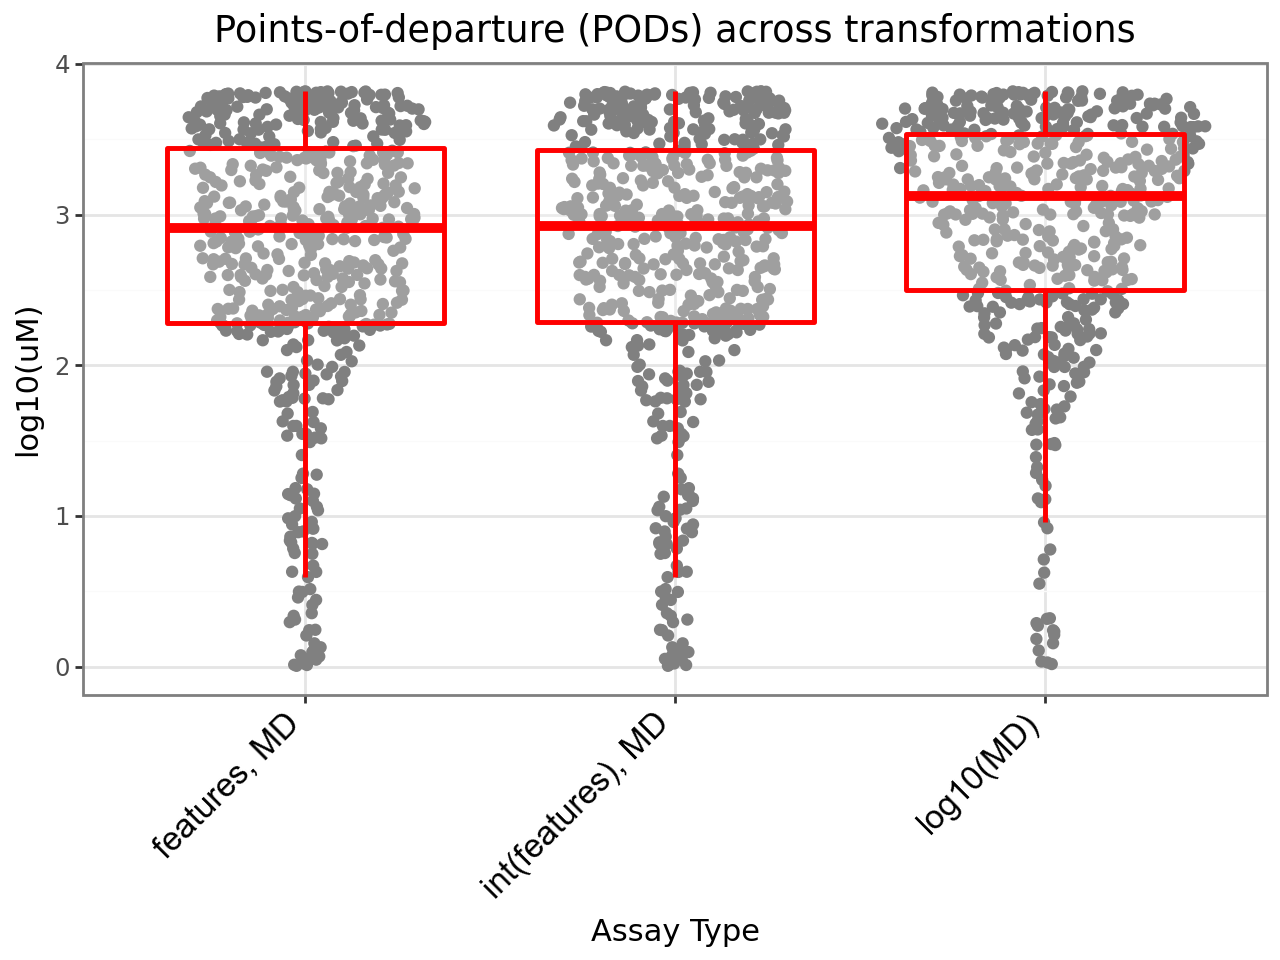

In [58]:
from plotnine import ggplot, aes, theme_bw, geom_boxplot, geom_sina, labs, theme, element_text, scale_x_discrete

plot = (
    ggplot(all_pods_long, aes(x='POD_Type', y='POD_Value')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1, outlier_alpha=0)
    + labs(title='Points-of-departure (PODs) across transformations', x='Assay Type', y='log10(uM)') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1, color='black', size=12, family='Arial')
    )
    + scale_x_discrete(labels={
        f"Metadata_{features}_POD": "features, MD", 
        f"Metadata_{features}_int_POD": "int(features), MD", 
        f"Metadata_{features}_log10_POD": "log10(MD)"
    })
)
plot.show()

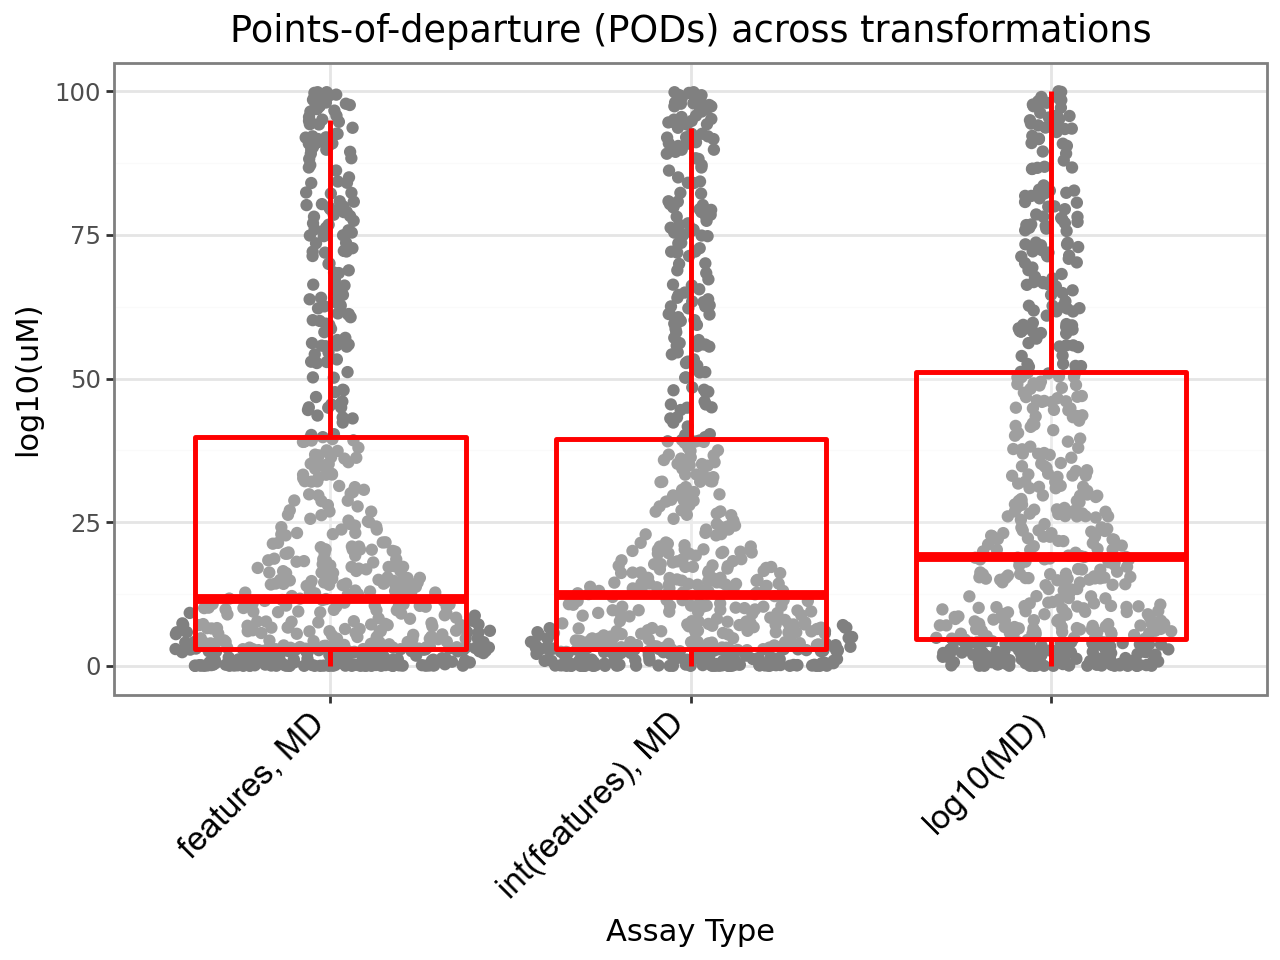

In [59]:
from plotnine import ggplot, aes, theme_bw, geom_boxplot, geom_sina, labs, theme, element_text, scale_x_discrete

plot = (
    ggplot(all_pods_um_long, aes(x='POD_Type', y='POD_Value')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1, outlier_alpha=0)
    + labs(title='Points-of-departure (PODs) across transformations', x='Assay Type', y='log10(uM)') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1, color='black', size=12, family='Arial')
    )
    + scale_x_discrete(labels={
        f"Metadata_{features}_POD_um": "features, MD", 
        f"Metadata_{features}_int_POD_um": "int(features), MD", 
        f"Metadata_{features}_log10_POD_um": "log10(MD)"
    })
)
plot.show()

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


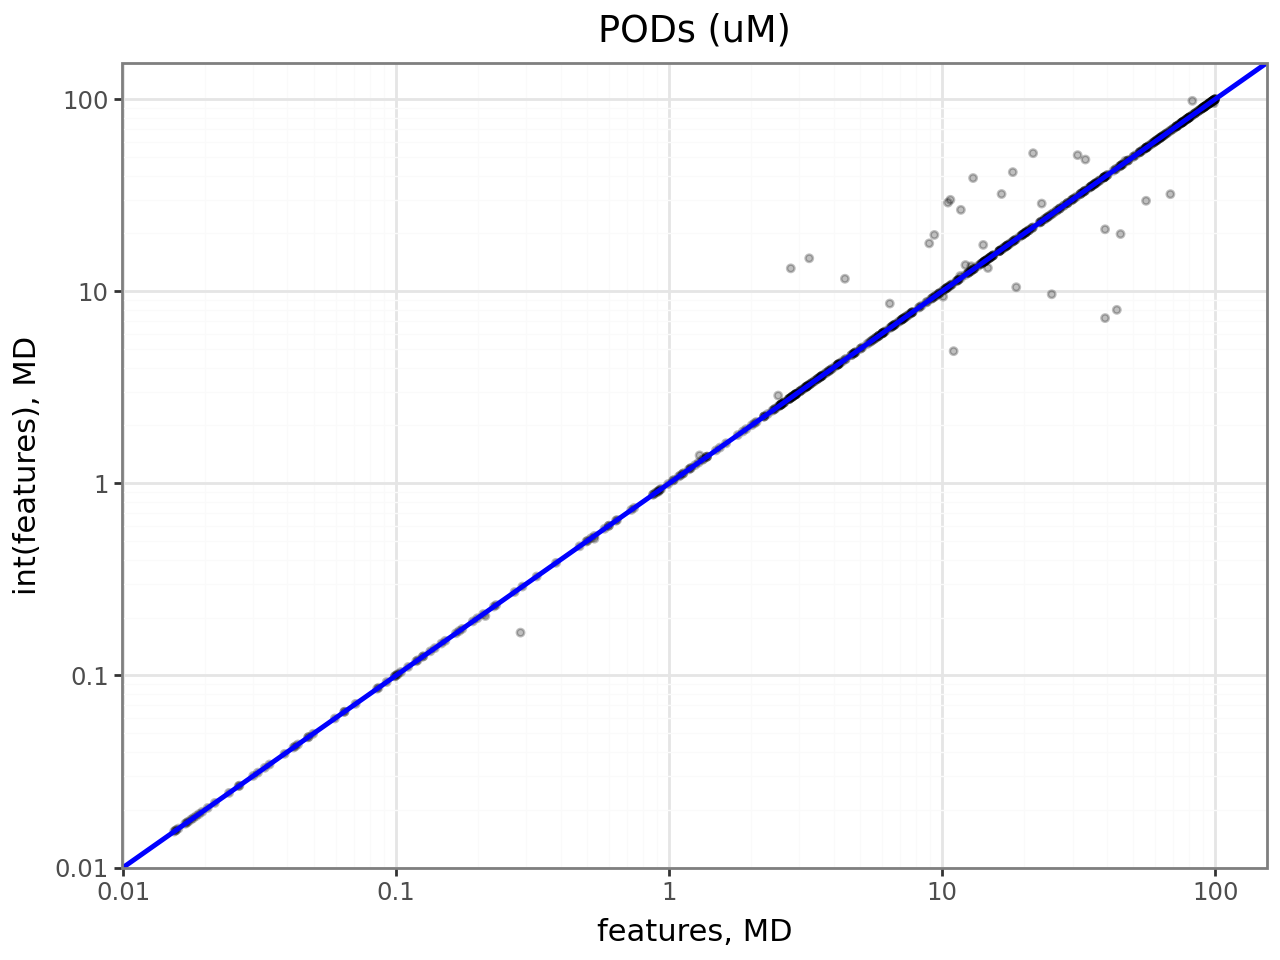

In [60]:
from plotnine import ggplot, aes, theme_bw, geom_point, labs, scale_x_log10, scale_y_log10, geom_abline

plot = (
    ggplot(all_pods_um, aes(x=f"Metadata_{features}_POD_um", y=f"Metadata_{features}_int_POD_um")) 
    + geom_point(alpha=0.25, size=1)
    + geom_abline(slope=1, intercept=0, color="blue", size=1)
    + labs(title='PODs (uM)', x='features, MD', y='int(features), MD') 
    + theme_bw()
    + scale_x_log10()
    + scale_y_log10()
)
plot.show()

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 54 rows containing missing values.


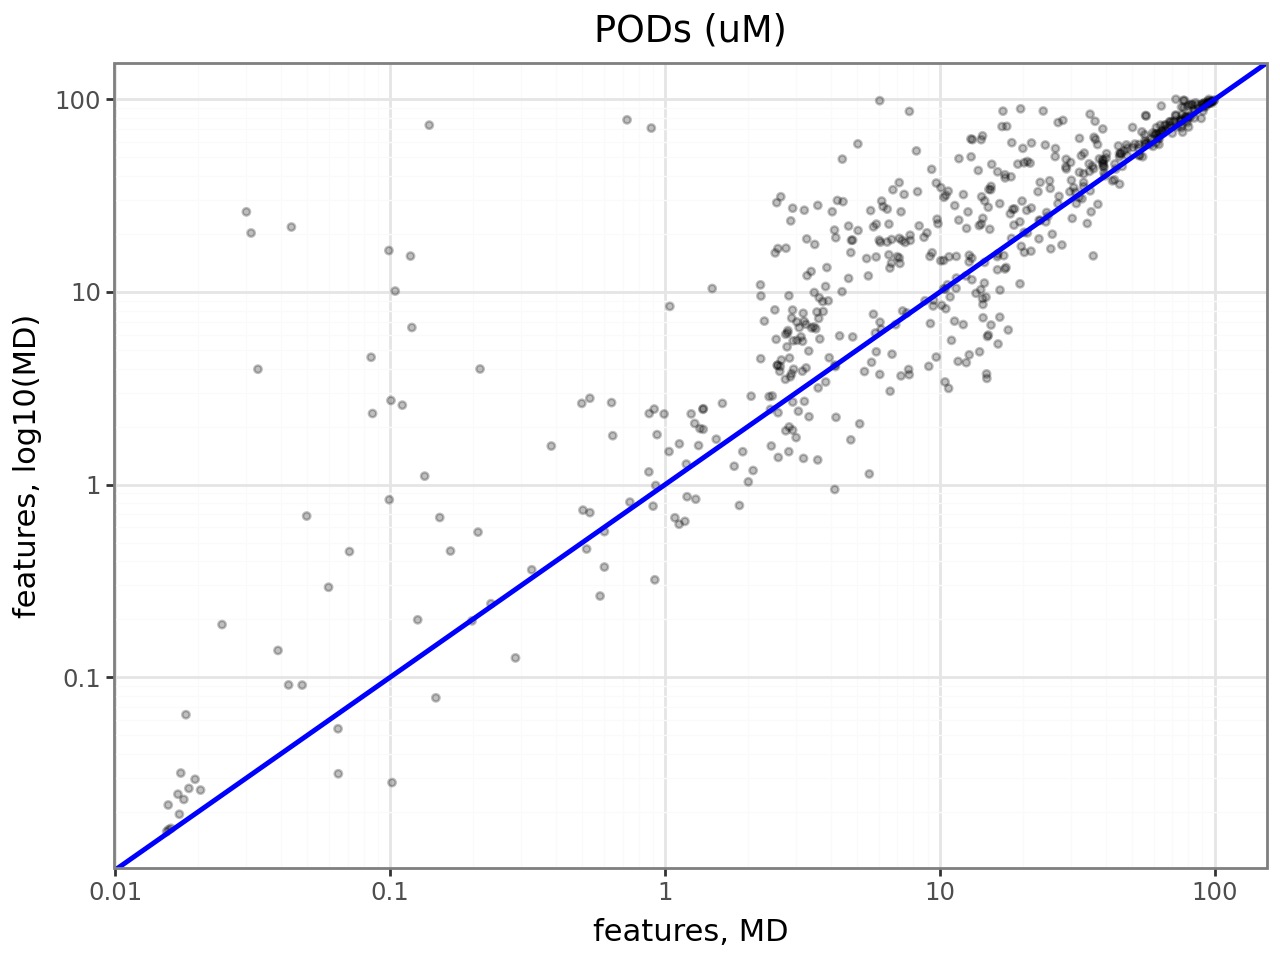

In [61]:
from plotnine import ggplot, aes, theme_bw, geom_point, labs, scale_x_log10, scale_y_log10, geom_abline

plot = (
    ggplot(all_pods_um, aes(x=f"Metadata_{features}_POD_um", y=f"Metadata_{features}_log10_POD_um")) 
    + geom_point(alpha=0.25, size=1)
    + geom_abline(slope=1, intercept=0, color="blue", size=1)
    + labs(title='PODs (uM)', x='features, MD', y='features, log10(MD)') 
    + theme_bw()
    + scale_x_log10()
    + scale_y_log10()
)
plot.show()